# Classification Algorithm Analysis
Notebook to analyze data generated by `classification_algo` in `crawler.py`.

## Setup

In [7]:

import os
import pandas as pd
import json
import statistics
from pathlib import Path
import yaml
import matplotlib.pyplot as plt
import matplotlib as mpl

from crawler import CrawlResults

from utils.utils import get_directories, get_domain
from utils.image_shingle import ImageShingle

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

##############################################################################

CRAWL_NAME = 'feb-12'
DATA_PATH = Path("/usr/project/xtmp/mml66/cookie-classify/") / CRAWL_NAME
ANALYSIS_PATH = Path("analysis") / CRAWL_NAME
ANALYSIS_PATH.mkdir(parents=True, exist_ok=True)

##############################################################################

"""
Load meta.yaml
"""

with open(DATA_PATH / "meta.yaml", "r") as stream:
    meta = yaml.safe_load(stream)

CRAWL_NAME = meta['CRAWL_NAME']
SITE_LIST_PATH = meta['SITE_LIST_PATH']
TOTAL_ACTIONS = meta['TOTAL_ACTIONS']
CLICKSTREAM_LENGTH = meta['CLICKSTREAM_LENGTH']

print(meta)

"""
CDN Domains
"""
cdn_domains = set()
with open("inputs/cdn/cnamechain.json") as file:
    data = json.load(file)
    for cdn in data:
        cdn_domains.add(get_domain(cdn[0]))

"""
Run Statistics
"""
# Sites that we wanted to crawl
sites_to_crawl = []
with open (DATA_PATH / SITE_LIST_PATH) as file:
    for line in file:
        sites_to_crawl.append(line.strip())

# Sites that we actually crawled
with open(DATA_PATH / "sites.json") as file:
    site_results: dict[str, CrawlResults] = json.load(file)

# Check whether we actually crawled all of the sites in our original site list. If not, it is likely that one of the workers hanged or was killed.
print(f"Crawled {len(site_results)}/{len(sites_to_crawl)} sites.")

"""
Check which crawled sites were actually successful.
A successful site must have:
1. an available landing page
2. no unexpected crawl exceptions
"""
successful_sites = []
for domain, result in site_results.items():
    result: CrawlResults
    if result["unexpected_exception"] is False and result["landing_page_down"] is False:
        successful_sites.append(domain)
print(f"Successfully crawled {len(successful_sites)}/{len(site_results)} sites.")

{'CLICKSTREAM_LENGTH': 5, 'CRAWL_NAME': 'feb-12', 'SITE_LIST_PATH': 'sites.txt', 'TOTAL_ACTIONS': 50}
Crawled 120/250 sites.
Successfully crawled 77/120 sites.


In [8]:
total_down_sites = 0
resolved_down_sites = 0
unexpected_exceptions = 0
for domain, result in site_results.items():
    result: CrawlResults
    if result["landing_page_down"]:
        total_down_sites += 1
        if result["url"]:
            resolved_down_sites += 1
    if result["unexpected_exception"]:
        unexpected_exceptions += 1
    
print(f"Total down sites: {total_down_sites}")
print(f"Sites that were initially available but then became unavailable: {resolved_down_sites}")
print(f"Unexpected exceptions: {unexpected_exceptions}")

Total down sites: 41
Sites that were initially available but then became unavailable: 2
Unexpected exceptions: 2


## Plot Helper Functions

In [9]:
def generate_pie_chart(freq_dict, title=None):
    """
    Generates a pie chart from a frequency dictionary.

    Args:
        freq_dict (dict): A dictionary where keys are categories and values are frequencies.
        title (str): The title of the pie chart. If None, no title is displayed.

    Returns:
        None: Displays the pie chart.
    """
    # Sort the keys alphabetically
    sorted_keys = sorted(freq_dict.keys())

    # Generate a list of distinct colors
    # Note: Increase the number of colors if you have more categories
    colors = ['gold', 'lightcoral', 'lightskyblue', 'lightgreen', 'lavender', 'orange', 'cyan', 'pink', 'yellowgreen', 'plum']

    # Create a color map by assigning each key a color
    color_map = {key: colors[i % len(colors)] for i, key in enumerate(sorted_keys)}

    # Extract the labels (keys) and sizes (values) from the frequency dictionary
    labels = freq_dict.keys()
    sizes = freq_dict.values()
    
    # Get the list of colors based on the order of labels
    pie_colors = [color_map[label] for label in labels]

    # Generate the pie chart
    plt.figure(figsize=(4, 4))  # Set the figure size
    plt.pie(sizes, labels=labels, colors=pie_colors, autopct='%1.1f%%', startangle=140)
    plt.axis('equal')  # Equal aspect ratio ensures the pie chart is circular.
    
    if title:
        plt.title(title)

    # Display the pie chart
    plt.show()


In [7]:
"""
Returns a dataframe which can be plotted as a CDF graph (see plot_cdf).

args:
    values: list of values to plot
"""
def get_cdf(values: list):
    s = pd.Series(values, name = 'value')
    df = pd.DataFrame(s)

    # Frequency
    stats_df = df \
    .groupby('value') \
    ['value'] \
    .agg('count') \
    .pipe(pd.DataFrame) \
    .rename(columns = {'value': 'frequency'})

    # PDF
    stats_df['pdf'] = stats_df['frequency'] / sum(stats_df['frequency'])

    # CDF
    stats_df['cdf'] = stats_df['pdf'].cumsum()
    stats_df = stats_df.reset_index()

    return stats_df

def plot_cdf(values: list, label: str, axis: list):
    """
    Plots a CDF graph.

    Args:
        values: list of values to plot
        label: label for the graph
        axis: axis limits
    """    
    mpl.rcParams.update(mpl.rcParamsDefault)

    cdf_df = get_cdf(values)

    plt.plot(cdf_df['value'], cdf_df['cdf'], label=label)

    plt.axis(axis)

    plt.xlabel(label)
    plt.ylabel('CDF')

    plt.grid(visible = True)

    plt.show()

### Time

Per site

In [19]:
times = []
for site in successful_sites:
    times.append(site_results[site]["total_time"])
print(f"Average time to crawl a site: {statistics.mean(times) / 60} minutes.")

Average time to crawl a site: 37.809197610126425 minutes.


Per worker

In [16]:
total_time = {}
for domain, result in site_results.items():
    task_id = result["SLURM_ARRAY_TASK_ID"]
    if task_id not in total_time:
        total_time[task_id] = 0
    total_time[task_id] += result["total_time"] / 60  # convert to minutes

# Convert the dictionary into a DataFrame
df = pd.DataFrame(list(total_time.items()), columns=['SLURM_ARRAY_TASK_ID', 'Total_Crawl_Time_Minutes'])

# Sort the DataFrame by 'Total_Crawl_Time' in ascending order
df_sorted = df.sort_values(by='Total_Crawl_Time_Minutes', ascending=True)

# Display the sorted DataFrame
print(df_sorted)
print(f"Average time {df_sorted['Total_Crawl_Time_Minutes'].mean()}.")

    SLURM_ARRAY_TASK_ID  Total_Crawl_Time_Minutes
11                   16                 27.549117
12                   17                 27.860858
19                   20                 44.525847
10                   25                 51.637777
17                    7                 74.443615
15                    6                 95.775417
21                    3                110.857946
13                    1                118.614587
6                    11                118.912205
0                    10                120.416900
1                     9                126.615456
2                    19                133.463096
7                    13                153.920057
18                    5                167.735049
20                    2                179.616941
3                    22                204.084511
16                   24                204.347627
4                     4                206.838354
5                    23                207.394029


### Clickstream length
Statisistics for both clickstream generation and traversal.

Failed elements clicked by type.
This means we were able to generate the clickstream, but unable to traverse it again.

In [10]:
click_failures = {}

for site in successful_sites:
    for type, failures in site_results[site]['traversal_failures'].items():
        if type not in click_failures:
            click_failures[type] = 0
        click_failures[type] += failures

click_failures

{'button': 18, 'link': 156, 'onclick': 13, 'pointer': 139}

Elements clicked by type

In [11]:
from itertools import chain

click_types = {}
for site in successful_sites:
    for _, click_type in list(chain.from_iterable(site_results[site]['clickstream'])):
        if click_type is None:
            continue
        if click_type not in click_types:
            click_types[click_type] = 0
        click_types[click_type] += 1

click_types

{'pointer': 1581, 'link': 1814, 'onclick': 75, 'button': 231}

- Pointer elements are the most common element in our clickstreams.
- Links are the most reliable element that we can click on. (They are the only type that decreased in proportion.)

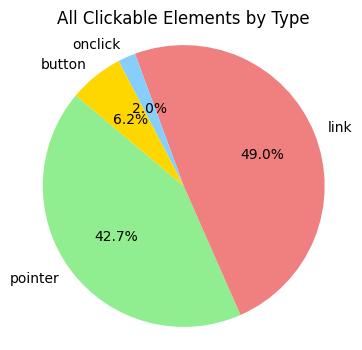

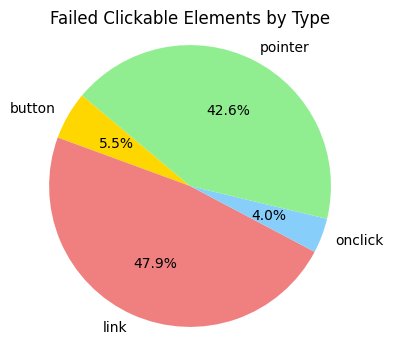

In [12]:
generate_pie_chart(click_types, title="All Clickable Elements by Type")
generate_pie_chart(click_failures, title="Failed Clickable Elements by Type")

Average clickstream length for each group.

- For baseline, this is the average length of the generated clickstream.
- For control and experimental, this is the average length of the successful traversal.

In [14]:
def count_actions(path: Path, name: str) -> int:
    """
    Counts the number of actions in a clickstream by counting the number of images in the directory.
    """    
    count = 0

    while True:
        if (path / f"{name}-{count+1}.png").is_file(): # We add 1 since the first image is the landing page (not an action)
            count += 1
        else:
            return count

def get_average_clickstream_length() -> pd.DataFrame:
    """
    Returns a dataframe with the average number of actions for each site.
    
    Should not be used to compute the average clickstream length for the entire crawl
    since we cannot take the average of averages.
    """    
    rows_list = []

    for domain in successful_sites:
        clickstreams = get_directories(site_results[domain]["data_path"])

        baseline_actions = 0
        controls_actions = 0
        experimental_actions = 0
        for clickstream in clickstreams:
            baseline_actions += count_actions(clickstream, "baseline")
            controls_actions += count_actions(clickstream, "control")
            experimental_actions += count_actions(clickstream, "experimental")

        rows_list.append({
            "domain": domain,
            "baseline_actions": baseline_actions / len(clickstreams),
            "control_actions": controls_actions / len(clickstreams),
            "experimental_actions": experimental_actions / len(clickstreams)
        })

    return pd.DataFrame(rows_list)

clickstream_lengths = get_average_clickstream_length()
clickstream_lengths


,domain,baseline_actions,control_actions,experimental_actions
0,twitter.com,5.000000,5.000000,5.000000
1,icloud.com,5.000000,5.000000,5.000000
2,googlevideo.com,5.000000,4.555556,3.111111
3,instagram.com,5.000000,5.000000,5.000000
4,doubleclick.net,5.000000,5.000000,5.000000
5,bing.com,5.000000,3.818182,3.727273
6,netflix.com,5.000000,4.400000,4.400000
7,cloudflare.com,5.000000,5.000000,5.000000
8,linkedin.com,5.000000,5.000000,5.000000
9,google.com,5.000000,3.909091,4.000000


In [15]:
def get_all_clickstream_lengths() -> tuple[list, list, list]:
    """
    Returns a tuple of lists containing the lengths of all clickstreams for each type.

    Returns: baseline_actions, controls_actions, experimental_actions
    """
    baseline_actions = []
    controls_actions = []
    experimental_actions = []
    for domain in successful_sites:
        clickstreams = get_directories(site_results[domain]["data_path"])

        for clickstream in clickstreams:
            baseline_actions.append(count_actions(clickstream, "baseline"))
            controls_actions.append(count_actions(clickstream, "control"))
            experimental_actions.append(count_actions(clickstream, "experimental"))
    
    return baseline_actions, controls_actions, experimental_actions

baseline_actions, controls_actions, experimental_actions = get_all_clickstream_lengths()
print(f"Average baseline length: {statistics.mean(baseline_actions)}")
print(f"Average control length: {statistics.mean(controls_actions)}")
print(f"Average experimental length: {statistics.mean(experimental_actions)}")

Average baseline length: 4.151279199110123
Average control length: 3.526140155728587
Average experimental length: 3.518353726362625


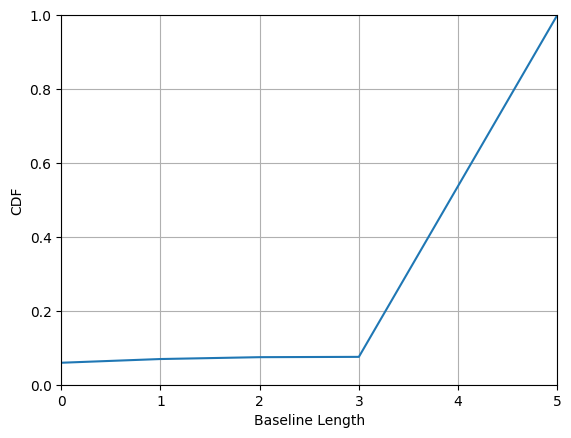

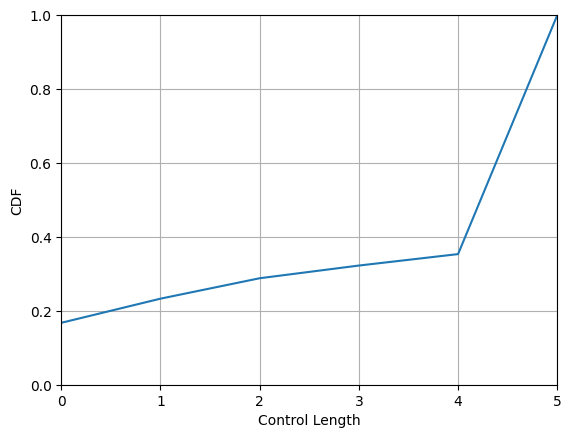

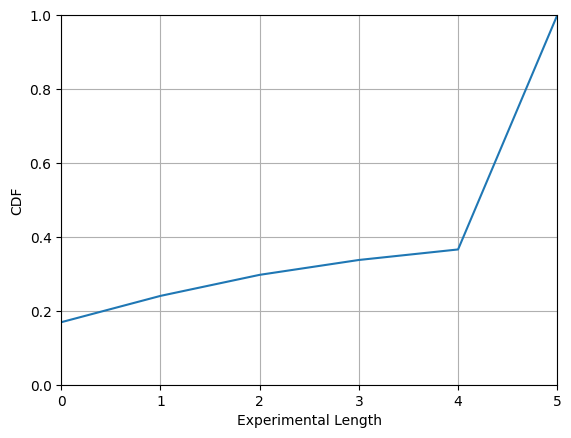

In [14]:
plot_cdf(baseline_actions, "Baseline Length", [0, 5, 0, 1])
plot_cdf(controls_actions, "Control Length", [0, 5, 0, 1])
plot_cdf(experimental_actions, "Experimental Length", [0, 5, 0, 1])

In [15]:
print(len(baseline_actions))
print(len(controls_actions))
print(len(experimental_actions))

1194
1194
1194


## Analysis

In [16]:
def screenshot_comparison() -> pd.DataFrame:
    rows_list = []

    for i, domain in enumerate(successful_sites):
        print(f"Analyzing site {i+1}/{len(successful_sites)}.")

        clickstreams = get_directories(site_results[domain]["data_path"])
        screenshot_sims = []
        for clickstream in clickstreams:
            for num_action in range(CLICKSTREAM_LENGTH+1):
                baseline_path = clickstream / f"baseline-{num_action}.png"
                control_path = clickstream / f"control-{num_action}.png"
                experimental_path = clickstream / f"experimental-{num_action}.png"
                
                if os.path.isfile(baseline_path) and os.path.isfile(control_path) and os.path.isfile(experimental_path):
                    CHUNK_SIZE = 40
                    baseline_shingle = ImageShingle(baseline_path, chunk_size = CHUNK_SIZE)
                    control_shingle = ImageShingle(control_path, chunk_size = CHUNK_SIZE)
                    experimental_shingle = ImageShingle(experimental_path, chunk_size = CHUNK_SIZE)

                    try:
                        screenshot_sims.append(ImageShingle.compare_with_control(baseline_shingle, control_shingle, experimental_shingle))
                    except ValueError as e:
                        print(e)

        if len(screenshot_sims) == 0:
            print(f"Skipping {domain} since no comparisons could be made.")
            continue

        screenshot_similarity = statistics.mean(screenshot_sims)
        sceenshot_difference = 1 - screenshot_similarity
        stdev = statistics.stdev(screenshot_sims)
        rows_list.append({
            "domain": domain,
            f"screenshot_difference": sceenshot_difference,
            f"stdev": stdev,
            f"samples": len(screenshot_sims),
        })

    return pd.DataFrame(rows_list)

# screenshots = screenshot_comparison()
# screenshots.to_csv(ANALYSIS_PATH / "screenshots.csv", index=False)

In [17]:
df = pd.read_csv(ANALYSIS_PATH / 'screenshots.csv')
df.sort_values(by='screenshot_difference')

,domain,screenshot_difference,stdev,samples
11,facebook.com,0.000000,0.000000,54
93,mzstatic.com,0.000000,0.000000,52
20,googleadservices.com,0.000000,0.000000,54
81,wikimedia.org,0.000000,0.000000,54
23,googleusercontent.com,0.000000,0.000000,54
24,cloudflare.net,0.000000,0.000000,54
94,youtube-nocookie.com,0.000000,0.000000,54
73,apache.org,0.000000,0.000000,54
33,google-analytics.com,0.000000,0.000000,54
36,mozilla.org,0.000000,0.000000,50


## Screenshot Difference CDF

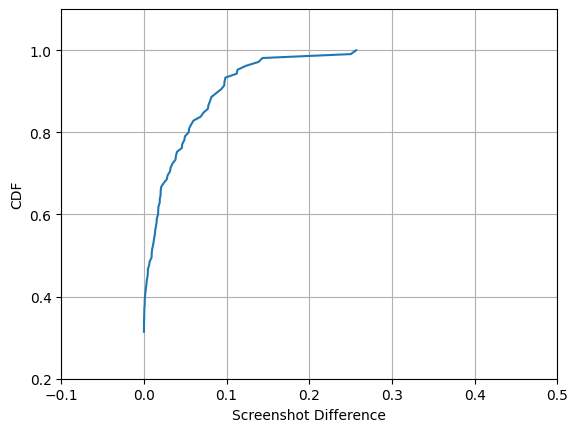

In [18]:
%matplotlib inline
plot_cdf(df['screenshot_difference'], 'Screenshot Difference', [-0.1, 0.5, 0.2, 1.1])

## Features Analysis

In [19]:
def jaccard_similarity(dict1, dict2):
    """
    Computes the Jaccard similarity between two frequency dictionaries.
    """    
    
    # Calculate the intersection of keys
    intersection_keys = set(dict1.keys()).intersection(set(dict2.keys()))
    intersection_sum = sum(min(dict1.get(k, 0), dict2.get(k, 0)) for k in intersection_keys)

    # Calculate the union of keys
    union_keys = set(dict1.keys()).union(set(dict2.keys()))
    union_sum = sum(max(dict1.get(k, 0), dict2.get(k, 0)) for k in union_keys)

    # Calculate Jaccard similarity
    if union_sum == 0:
        return 0  # to handle division by zero

    return intersection_sum / union_sum

In [20]:
def compare(list1: list[dict], list2: list[dict]):
    action_sims = []
    for dict1, dict2 in zip(list1, list2):
        action_sims.append(jaccard_similarity(dict1, dict2))

    return action_sims

In [21]:
def compare_features(feature: str, comparison: tuple[str, str]) -> pd.DataFrame:
    rows_list = []

    for i, domain in enumerate(successful_sites):
        print(f"Analyzing site {i+1}/{len(successful_sites)}.")
        clickstreams = get_directories(site_results[domain]["data_path"])

        all_action_sims = []
        for clickstream in clickstreams:
            data_path = clickstream / "features.json"
            with open(data_path) as data:
                data = json.load(data)

            all_action_sims.extend(compare(data[feature][comparison[0]], data[feature][comparison[1]]))

        website_similarity = statistics.mean(all_action_sims)
        stdev = statistics.stdev(all_action_sims)
        website_difference = 1 - website_similarity

        website = os.path.basename(os.path.normpath(domain))
        rows_list.append({
            "website": website,
            f"mean diff": website_difference,
            f"stdev": stdev,
        })

    return pd.DataFrame(rows_list)

def merge_experiments(feature: str):
    A = compare_features(feature, ("baseline", "control"))
    B = compare_features(feature, ("baseline", "experimental"))
    diff = B["mean diff"] - A["mean diff"]

    df = pd.concat([A, B, diff], axis = 1, keys=(["control", "experimental", "difference in difference"]))
    df.name = feature
    return df

features: dict[str, None | pd.DataFrame] = {
    "innerText": None,
    "links": None,
    "img": None,
}
for feature in features:
    features[feature] = merge_experiments(feature)
    # results[feature].to_csv(f'analysis/{CRAWL_NAME}_{feature}.csv', index=False)


Analyzing site 1/105.
Analyzing site 2/105.
Analyzing site 3/105.
Analyzing site 4/105.
Analyzing site 5/105.
Analyzing site 6/105.
Analyzing site 7/105.
Analyzing site 8/105.
Analyzing site 9/105.
Analyzing site 10/105.
Analyzing site 11/105.
Analyzing site 12/105.
Analyzing site 13/105.
Analyzing site 14/105.
Analyzing site 15/105.
Analyzing site 16/105.
Analyzing site 17/105.
Analyzing site 18/105.
Analyzing site 19/105.
Analyzing site 20/105.
Analyzing site 21/105.
Analyzing site 22/105.
Analyzing site 23/105.
Analyzing site 24/105.
Analyzing site 25/105.
Analyzing site 26/105.
Analyzing site 27/105.
Analyzing site 28/105.
Analyzing site 29/105.
Analyzing site 30/105.
Analyzing site 31/105.
Analyzing site 32/105.
Analyzing site 33/105.
Analyzing site 34/105.
Analyzing site 35/105.
Analyzing site 36/105.
Analyzing site 37/105.
Analyzing site 38/105.
Analyzing site 39/105.
Analyzing site 40/105.
Analyzing site 41/105.
Analyzing site 42/105.
Analyzing site 43/105.
Analyzing site 44/10

In [22]:
features["innerText"]

control                               experimental  \
                   website mean diff     stdev                website   
0               icloud.com  0.000000  0.000000             icloud.com   
1              netflix.com  0.001643  0.004417            netflix.com   
2              twitter.com  0.000000  0.000000            twitter.com   
3               github.com  0.003750  0.004412             github.com   
4              gstatic.com  0.000000  0.000000            gstatic.com   
5     googletagmanager.com  0.000000  0.000000   googletagmanager.com   
6           googleapis.com  0.000000  0.000000         googleapis.com   
7            pinterest.com  0.275228  0.360552          pinterest.com   
8               google.com  0.019679  0.135960             google.com   
9                apple.com  0.020409  0.139602              apple.com   
10           instagram.com  0.000000  0.000000          instagram.com   
11            facebook.com  0.004984  0.024032           facebook.com   
12           amazonaws.com  0.014415  0.020943          amazonaws.com   
13               adobe.com  0.143361  0.301465              adobe.com   
14                live.com  0.008022  0.034365               live.com   
15             youtube.com  0.549389  0.283527            youtube.com   
16                bing.com  0.373291  0.321483               bing.com   
17                youtu.be  0.569050  0.311824               youtu.be   
18                  ui.com  0.000000  0.000000                 ui.com   
19               azure.com  0.013155  0.019373              azure.com   
20    googleadservices.com  0.000000  0.000000   googleadservices.com   
21           wikipedia.org  0.000794  0.005832          wikipedia.org   
22           wordpress.com  0.001331  0.003081          wordpress.com   
23   googleusercontent.com  0.000000  0.000000  googleusercontent.com   
24          cloudflare.net  0.026126  0.126936         cloudflare.net   
25             tiktokv.com  0.316129  0.206293            tiktokv.com   
26   googlesyndication.com  0.016397  0.119373  googlesyndication.com   
27            whatsapp.net  0.000000  0.000000           whatsapp.net   
28               gandi.net  0.001999  0.014132              gandi.net   
29                 ntp.org  0.018924  0.136460                ntp.org   
30             outlook.com  0.034643  0.168697            outlook.com   
31            whatsapp.com  0.015257  0.112112           whatsapp.com   
32               vimeo.com  0.001762  0.011148              vimeo.com   
33    google-analytics.com  0.000000  0.000000   google-analytics.com   
34                  bit.ly  0.006928  0.021744                 bit.ly   
35              fastly.net  0.005536  0.019222             fastly.net   
36             mozilla.org  0.000000  0.000000            mozilla.org   
37                 zoom.us  0.000000  0.000000                zoom.us   
38               github.io  0.001047  0.005246              github.io   
39               yandex.ru  0.586560  0.184380              yandex.ru   
40           office365.com  0.073096  0.208730          office365.com   
41                pki.goog  0.000276  0.001546               pki.goog   
42                    t.co  0.000000  0.000000                   t.co   
43              tiktok.com  0.326058  0.239288             tiktok.com   
44              roblox.com  0.000193  0.000995             roblox.com   
45              paypal.com  0.000107  0.000782             paypal.com   
46              meraki.com  0.000000  0.000000             meraki.com   
47           wordpress.org  0.025559  0.061565          wordpress.org   
48                  goo.gl  0.000000  0.000000                 goo.gl   
49              flickr.com  0.163331  0.164310             flickr.com   
50              amazon.com  0.256963  0.344393             amazon.com   
51               baidu.com  0.039931  0.084875              baidu.com   
52            gravatar.com  0.000000  0.000000           gravatar.com   
53  

In [23]:
features["links"]

control                               experimental  \
                   website mean diff     stdev                website   
0               icloud.com  0.000000  0.000000             icloud.com   
1              netflix.com  0.003608  0.008729            netflix.com   
2              twitter.com  0.000000  0.000000            twitter.com   
3               github.com  0.017141  0.020383             github.com   
4              gstatic.com  0.000000  0.000000            gstatic.com   
5     googletagmanager.com  0.000000  0.000000   googletagmanager.com   
6           googleapis.com  0.000000  0.000000         googleapis.com   
7            pinterest.com  0.323823  0.411534          pinterest.com   
8               google.com  0.020164  0.141402             google.com   
9                apple.com  0.071567  0.217700              apple.com   
10           instagram.com  0.296571  0.069831          instagram.com   
11            facebook.com  0.139671  0.074696           facebook.com   
12           amazonaws.com  0.000479  0.000739          amazonaws.com   
13               adobe.com  0.143447  0.324284              adobe.com   
14                live.com  0.020972  0.076925               live.com   
15             youtube.com  0.586407  0.207361            youtube.com   
16                bing.com  0.670611  0.242781               bing.com   
17                youtu.be  0.587876  0.237059               youtu.be   
18                  ui.com  0.000000  0.000000                 ui.com   
19               azure.com  0.000646  0.000952              azure.com   
20    googleadservices.com  0.000000  0.000000   googleadservices.com   
21           wikipedia.org  0.000000  0.000000          wikipedia.org   
22           wordpress.com  0.001418  0.010030          wordpress.com   
23   googleusercontent.com  0.000000  0.000000  googleusercontent.com   
24          cloudflare.net  0.018519  0.136083         cloudflare.net   
25             tiktokv.com  0.345996  0.241524            tiktokv.com   
26   googlesyndication.com  0.000000  0.000000  googlesyndication.com   
27            whatsapp.net  0.000000  0.000000           whatsapp.net   
28               gandi.net  0.064513  0.219115              gandi.net   
29                 ntp.org  0.014957  0.107858                ntp.org   
30             outlook.com  0.034188  0.159542            outlook.com   
31            whatsapp.com  0.012004  0.065111           whatsapp.com   
32               vimeo.com  0.000472  0.003502              vimeo.com   
33    google-analytics.com  0.004274  0.017786   google-analytics.com   
34                  bit.ly  0.026137  0.048909                 bit.ly   
35              fastly.net  0.006158  0.016849             fastly.net   
36             mozilla.org  0.029162  0.076728            mozilla.org   
37                 zoom.us  0.041394  0.113969                zoom.us   
38               github.io  0.001931  0.009937              github.io   
39               yandex.ru  0.833999  0.089912              yandex.ru   
40           office365.com  0.081737  0.239001          office365.com   
41                pki.goog  0.000000  0.000000               pki.goog   
42                    t.co  0.000000  0.000000                   t.co   
43              tiktok.com  0.372630  0.271262             tiktok.com   
44              roblox.com  0.000000  0.000000             roblox.com   
45              paypal.com  0.000141  0.001025             paypal.com   
46              meraki.com  0.000000  0.000000             meraki.com   
47           wordpress.org  0.017486  0.048784          wordpress.org   
48                  goo.gl  0.000000  0.000000                 goo.gl   
49              flickr.com  0.099302  0.151406             flickr.com   
50              amazon.com  0.677276  0.220830             amazon.com   
51               baidu.com  0.011407  0.024166              baidu.com   
52            gravatar.com  0.000000  0.000000           gravatar.com   
53  

In [24]:
features["img"]

control                               experimental  \
                   website mean diff     stdev                website   
0               icloud.com  0.757202  0.063369             icloud.com   
1              netflix.com  0.018868  0.059020            netflix.com   
2              twitter.com  1.000000  0.000000            twitter.com   
3               github.com  0.234183  0.388529             github.com   
4              gstatic.com  1.000000  0.000000            gstatic.com   
5     googletagmanager.com  1.000000  0.000000   googletagmanager.com   
6           googleapis.com  1.000000  0.000000         googleapis.com   
7            pinterest.com  0.380640  0.415313          pinterest.com   
8               google.com  0.019794  0.139963             google.com   
9                apple.com  0.385396  0.486460              apple.com   
10           instagram.com  0.000000  0.000000          instagram.com   
11            facebook.com  0.003704  0.027217           facebook.com   
12           amazonaws.com  0.012414  0.030243          amazonaws.com   
13               adobe.com  0.348440  0.307581              adobe.com   
14                live.com  0.078501  0.048519               live.com   
15             youtube.com  0.302882  0.191118            youtube.com   
16                bing.com  0.308070  0.272860               bing.com   
17                youtu.be  0.334147  0.227070               youtu.be   
18                  ui.com  0.004871  0.018177                 ui.com   
19               azure.com  0.008399  0.002952              azure.com   
20    googleadservices.com  1.000000  0.000000   googleadservices.com   
21           wikipedia.org  0.000000  0.000000          wikipedia.org   
22           wordpress.com  0.396198  0.405142          wordpress.com   
23   googleusercontent.com  1.000000  0.000000  googleusercontent.com   
24          cloudflare.net  0.664198  0.367885         cloudflare.net   
25             tiktokv.com  0.470466  0.256432            tiktokv.com   
26   googlesyndication.com  0.037736  0.192380  googlesyndication.com   
27            whatsapp.net  0.044974  0.191912           whatsapp.net   
28               gandi.net  0.206667  0.403443              gandi.net   
29                 ntp.org  0.006410  0.046225                ntp.org   
30             outlook.com  0.123469  0.196343            outlook.com   
31            whatsapp.com  0.056463  0.191991           whatsapp.com   
32               vimeo.com  0.109077  0.297819              vimeo.com   
33    google-analytics.com  0.000000  0.000000   google-analytics.com   
34                  bit.ly  0.044444  0.156226                 bit.ly   
35              fastly.net  0.539435  0.221682             fastly.net   
36             mozilla.org  0.000000  0.000000            mozilla.org   
37                 zoom.us  0.204866  0.229053                zoom.us   
38               github.io  0.329705  0.465316              github.io   
39               yandex.ru  0.714535  0.158388              yandex.ru   
40           office365.com  0.094916  0.180279          office365.com   
41                pki.goog  0.160000  0.370328               pki.goog   
42                    t.co  0.000000  0.000000                   t.co   
43              tiktok.com  0.471618  0.280240             tiktok.com   
44              roblox.com  0.000000  0.000000             roblox.com   
45              paypal.com  0.050658  0.202454             paypal.com   
46              meraki.com  0.095905  0.124374             meraki.com   
47           wordpress.org  0.195444  0.161019          wordpress.org   
48                  goo.gl  0.000000  0.000000                 goo.gl   
49              flickr.com  0.839882  0.370277             flickr.com   
50              amazon.com  0.369272  0.386016             amazon.com   
51               baidu.com  0.026455  0.043058              baidu.com   
52            gravatar.com  0.800389  0.314853           gravatar.com   
53  

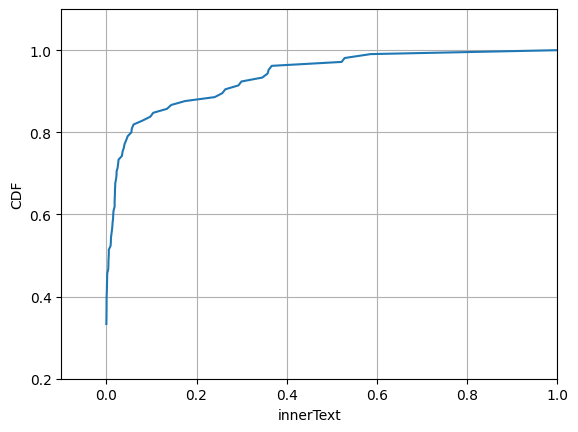

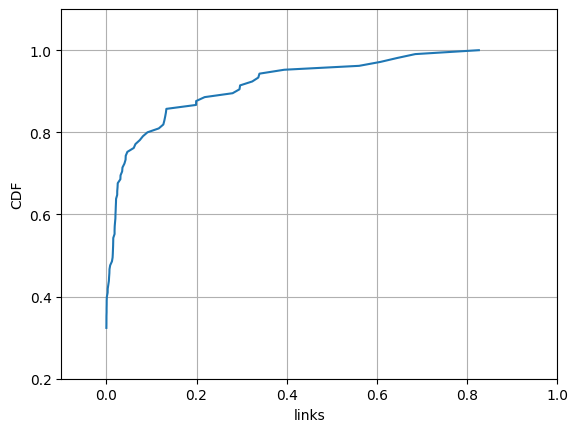

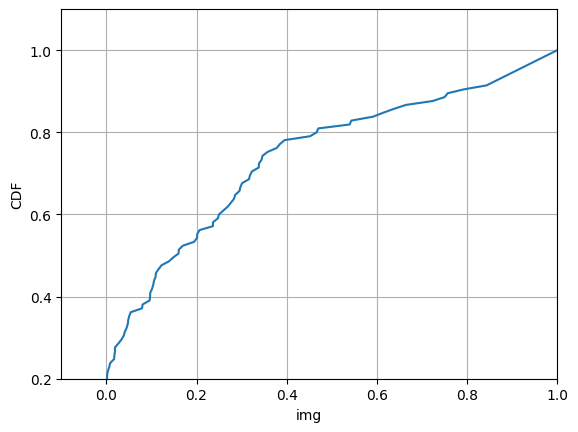

In [30]:
# Difference Baseline / Experimental
plot_cdf(list(features["innerText"]["experimental"]["mean diff"]), "innerText", [-0.1, 1, 0.2, 1.1])
plot_cdf(list(features["links"]["experimental"]["mean diff"]), "links", [-0.1, 1, 0.2, 1.1])
plot_cdf(list(features["img"]["experimental"]["mean diff"]), "img", [-0.1, 1, 0.2, 1.1])

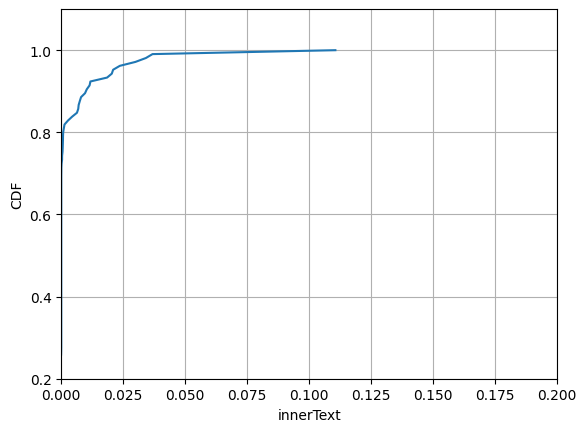

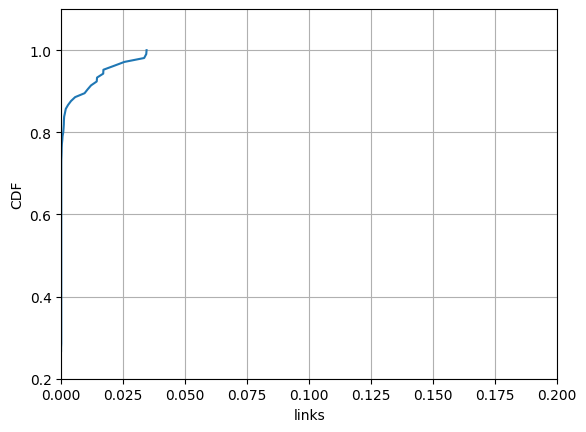

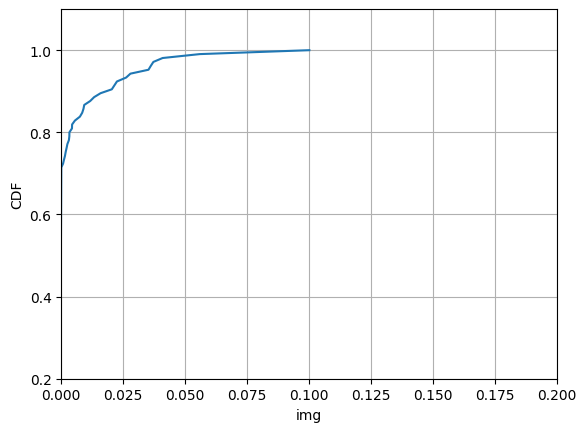

In [31]:
# Difference of Difference
plot_cdf(list(features["innerText"]["difference in difference"]["mean diff"]), "innerText", [0, 0.2, 0.2, 1.1])
plot_cdf(list(features["links"]["difference in difference"]["mean diff"]), "links", [0, 0.2, 0.2, 1.1])
plot_cdf(list(features["img"]["difference in difference"]["mean diff"]), "img", [0, 0.2, 0.2, 1.1])

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def plot_comparison(df: pd.DataFrame, title: str):
    # Set the x-axis labels to be the websites
    websites = df["control"]["website"]
    x = np.arange(len(websites))  # Use numpy.arange for better control

    # Set the data for the second CSV (remove-third-party)
    mean_diff_control = df["control"]["mean diff"]
    stdev_control = df["control"]["stdev"]

    # Set the data for the first CSV (remove-all)
    mean_diff_experimental = df["experimental"]["mean diff"]
    stdev_experimental = df["experimental"]["stdev"]

    # Create the figure and axes for the plot
    _, ax = plt.subplots(figsize=(12, 6))

    # Define a color for the bars and error bars
    bar_color = "skyblue"

    # Width of the bars
    width = 0.35

    # Bars
    bars1 = ax.bar(x - width/2, mean_diff_control, width=width, label="Control", color="lightcoral", alpha=0.7)
    bars2 = ax.bar(x + width/2, mean_diff_experimental, width=width, label="Experimental", color=bar_color, alpha=0.7)

    # Set the x-axis labels
    ax.set_xticks(x)
    ax.set_xticklabels(websites, rotation=90)

    # Set labels and title
    ax.set_xlabel("Website")
    ax.set_ylabel("Mean Difference")
    ax.set_title(f"{title} feature comparison (10 clickstreams, length 5)")

    # Add a legend
    ax.legend()

    # Customize the error bars to match the bar color and add horizontal lines
    # error_kw = {'capsize': 5, 'ecolor': 'lightcoral', 'color': 'lightcoral'}
    # ax.bar(x - width/2, mean_diff_control, width=width, yerr=stdev_control, alpha=0, error_kw=error_kw)
    
    # error_kw = {'capsize': 5, 'ecolor': bar_color, 'color': bar_color}
    # ax.bar(x + width/2, mean_diff_experimental, width=width, yerr=stdev_experimental, alpha=0, error_kw=error_kw)

    # Add text labels for the values at the top of each bar
    for bar1, bar2 in zip(bars1, bars2):
        height1 = bar1.get_height()
        height2 = bar2.get_height()
        ax.annotate(f"{height1:.2f}", (bar1.get_x() + bar1.get_width() / 2, height1),
                    ha="center", va="bottom", fontsize=8)
        ax.annotate(f"{height2:.2f}", (bar2.get_x() + bar2.get_width() / 2, height2),
                    ha="center", va="bottom", fontsize=8)

    # Show the plot
    plt.tight_layout()
    plt.show()

for feature in site_results:
    plot_comparison(site_results[feature], feature)